# Описание проекта "Разведывательный анализ данных".

## Цель проекта.



# Цель проекта.
Целью проекта является проведение разведывательного анализа данных предложенного набора данных для его подготовки к обучению и тестированию ML-модели.



In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import warnings
import random
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# Добавим метод чтобы красиво отобржать текст
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [77]:
"Загружаем датасет"

stud_math = pd.read_csv(r'C:\Users\kuvak\Downloads\stud_math.csv')

In [76]:
# Определяем нужные нам функции

def first_look(df: pd.DataFrame, column: object, outlier_bounds: dict, descriptions: dict):
    '''
    Функция для осмотра переменных
    '''
    printmd('### ' + str(column))
    if column in list(descriptions.keys()):
        printmd(descriptions[column])
    # Проверка на строковый тип данных
    if df.loc[:, col].dtypes == np.dtype('O'):
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.countplot(df.loc[:, column], ax=ax)
        plt.show()
        # Print misses percent
        misses = (1 - (df[column].count() / df.shape[0]))
        print('Процент пропусков: ', round(misses*100, 2), "%")
    else:
        # Prepare plot data frame
        plot_df = pd.DataFrame({'Распределение': df[column]})
        if search_mistakes(df, column, outlier_bounds):
            low, high = IQR_outlier(df, column, verbose=False)
            plot_df['Распределение в границах выбросов'] = df.loc[df.loc[:,
                                                                         column].between(low, high)][column]
        # Draw plot
        fig, ax = plt.subplots(figsize=(7 * plot_df.shape[1], 4))
        plot_df.hist(ax=ax)
        plt.show()
        # Print misses percent
        misses = (1 - (df[column].count() / df.shape[0]))
        print('Процент пропусков: ', round(misses*100, 2), "%")


def search_mistakes(df: pd.DataFrame, column: object, outlier_bounds: dict) -> bool:
    '''
    Функция проверяет переменные на наличие ошибок в данных
    '''
    if column not in list(outlier_bounds.keys()):
        low, high = IQR_outlier(df, column, verbose=False)
        if df[column].min() < low or df[column].max() > high:
            out_df = df.loc[(~df.loc[:, column].between(
                low, high)) & pd.notnull(df.loc[:, column])]
            print('Найдены ошибки в количестве: ', out_df.shape[0])
            if out_df.shape[0] > 10:
                print('\nПервые 10:')
            display(out_df[:10])
            return True
        else:
            print('Выбросы не обнаружены')
    else:
        low, high = outlier_bounds[column][0], outlier_bounds[column][1]
        if df[column].min() < low or df[column].max() > high:
            out_df = df.loc[(~df.loc[:, column].between(
                low, high)) & pd.notnull(df.loc[:, column])]
            print('Найдены выбросы по IQR в количестве: ', out_df.shape[0])
            if out_df.shape[0] > 10:
                print('\nПервые 10:')
            display(out_df[:10])
            return True
        else:
            print('Ошибки не обнаружены')


def IQR_outlier(df: pd.DataFrame, column: object, verbose: bool = True) -> tuple:
    '''
    Функция для отображения границ межквартильного размаха
    '''
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    if verbose:
        print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
              "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return (low, high)


def fill_na(df: pd.DataFrame, column: object, method='auto') -> pd.Series:
    '''
    Функция для заполнения пропущенных значений
    Варианты аргумента method:
    mode - заполнение наиболее частовстречаемым значением
    median - заполнение медианой
    density - случайное заполнение с учетом вероятности появления
    auto - для численных переменных медиана, для номинативных и смешанных density
    '''
    if method == 'auto':
        if (df[column].dtypes == np.dtype('O')) and (df[column].nunique() < 10):
            prob = df[column].value_counts(normalize=True)
            ind = df[df[column].isna() == True].index
            fill_list = pd.Series(random.choices(
                prob.index, prob, k=df[column].isna().sum()))
            fill_list.index = ind
            return df[column].fillna(fill_list)
        else:
            median = df[column].median()
            return df[column].fillna(median)
    elif method == 'mode':
        mode = df[column].mode()[0]
        return df[column].fillna(mode)
    elif method == 'median':
        median = df[column].median()
        return df[column].fillna(median)
    elif method == 'density':
        prob = df[column].value_counts(normalize=True)
        ind = df[df[column].isna() == True].index
        fill_list = pd.Series(random.choices(
            prob.index, prob, k=df[column].isna().sum()))
        fill_list.index = ind
        return df[column].fillna(fill_list)
    else:
        raise NameError(
            'method может принимать следующие значения: mode, median, density, auto')


def get_boxplot(df: pd.DataFrame, column: object, ax_y='score') -> None:
    '''
    Функция для отображения boxplot-графиков для номинативных и смешанных переменных
    '''
    fig, ax = plt.subplots(figsize=(8, 4))
    box_plot = sns.boxplot(x=column, y=ax_y, data=df, ax=ax)
    cnt = df[column].value_counts()
    medians = stud_math.groupby([column])[ax_y].median()
    vertical_offset = stud_math.groupby([column])[ax_y].median() * 0.12
    x = stud_math[column].unique()
    x = list(filter(lambda v: v == v, x))
    if df.loc[:, col].dtypes != np.dtype('O'):
        x = sorted(x)
    for xtick, ytick in zip(list(box_plot.get_xticks()), x):
        box_plot.text(xtick, medians.loc[ytick]-vertical_offset[ytick], cnt.loc[ytick],
                      horizontalalignment='center', size=15, color='w', weight='semibold')
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(df: pd.DataFrame, column: object, target='score') -> bool:
    '''
    Функция для проведения теста Стьюдента для номинативных и смешанных переменных
    '''
    cols = df.loc[:, column].value_counts()
    cols = cols[cols > 15].index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target].dropna(),
                     df.loc[df.loc[:, column] == comb[1], target].dropna()).pvalue \
                <= 0.075/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            return True
            break

In [83]:
"Первичный осмотр данных"

stud_math.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


In [84]:
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [ ]:
В датасете содержится информация о 395 учениках. 
В первых 3-х столбцах (shool, sex, age) нет пропусков, остальные имеют в значениях пропуски от 1 до 45. 

Данные представлены в 30 столбцах, из них 17 столбцов имеют строковый тип, остальные 13 - числовой тип.

Также в числовые столбцы попали упорядоченные категориальные переменные, у которых значения закодированы числовым диапазоном.

Поэтому по факту у нас есть только 3 истинно количественных переменных: 
age (непрерывная количиственная), absences и score (дискретные количественные переменные), при этом score - целевая переменная.

Так как в некоторых столбцах некорректное написание заголовков, приведём названия к нормальному виду.

In [85]:
# Приведем названия колонок к нормальному виду:
stud_math.columns = [i.lower() for i in stud_math.columns]
stud_math.rename({'studytime, granular': 'studytime_granular'},
                 inplace=True, axis=1)

In [86]:
#Проверим датасет на наличие дубликатов:
if len(stud_math)>len(stud_math.drop_duplicates()):
    print('Дубликаты есть')
    display(stud_math[stud_math.duplicated()])
else:
    print('Дубликатов нет')


Дубликатов нет


<AxesSubplot:>

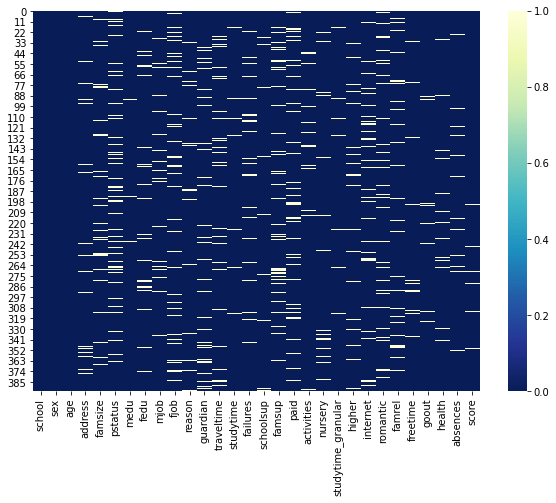

In [87]:
# Смотрим как распеделены пропуски по датасету:
plt.figure(figsize=(10, 7))  # размер тепловой карты
sns.heatmap(stud_math.isnull(), cmap="YlGnBu_r")

In [ ]:
Мы видим, что пропуски распределены примерно равномерно по всему датасету. Концентрации в строках не наблюдается. 
Значит удаление в качестве решения не подходит.

In [88]:
# Проверим какое максимальное количество пропусков в строке:
Count_rows = stud_math.apply(lambda x: sum(x.isnull()), axis=1).value_counts()
percent_nans = round(pd.Series(
    Count_rows.index/stud_math.shape[1]*100)).sort_values(ascending=False).astype(str)+' %'
misses = max(stud_math.apply(lambda x: sum(
    x.isnull()), axis=1))/stud_math.shape[1]
print('Максимум незаполненных строк в датафрейме:', round(misses*100, 2), "%")
pd.DataFrame({'Количество случаев строке': Count_rows,
              'Количество пропусков в строке': Count_rows.index,
              'Процент незаполненных значений в строке': percent_nans}).sort_values('Количество пропусков в строке', ascending=False).reset_index().drop('index', axis=1)

Максимум незаполненных строк в датафрейме: 20.0 %


,Количество случаев строке,Количество пропусков в строке,Процент незаполненных значений в строке
0,2,6,20.0 %
1,5,5,17.0 %
2,15,4,13.0 %
3,47,3,10.0 %
4,131,2,7.0 %
5,97,1,3.0 %
6,98,0,0.0 %


In [ ]:
Процент не достаточно высок, чтобы удаленять отдельные строки с пропусками.

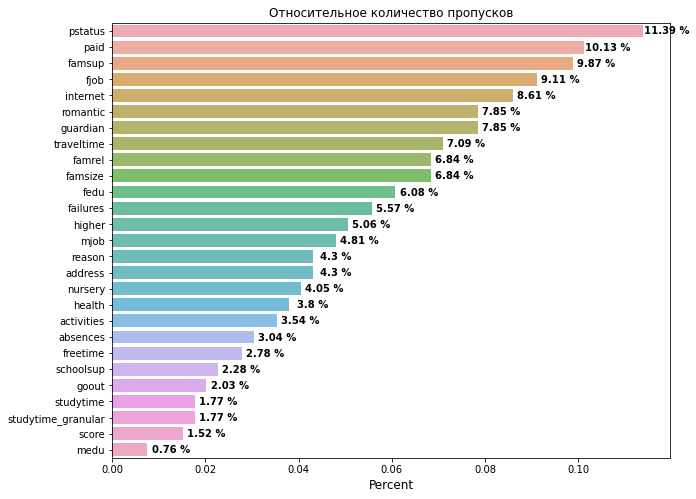

In [89]:
# Считаем процент пропусков
per_nans = pd.DataFrame(1-stud_math.count()/stud_math.shape[0]).reset_index().rename({0: 'percent'},
                                                                                     axis=1).sort_values('percent', ascending=False).query('percent>0')
# Строим график относительного количества пропущенных значений:
fig, ax = plt.subplots(figsize=(10, 8))
bar_plot = sns.barplot(x='percent', y='index',
                       data=per_nans, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
    bar_plot.text(per_nans.iloc[ytick][1]+0.005, ytick+0.2, str(round(per_nans.iloc[ytick][1]*100, 2))+' %',
                  horizontalalignment='center', size=10, color='black', weight='semibold')
plt.title('Относительное количество пропусков')
plt.ylabel('')
plt.xlabel('Percent', fontsize=12)
plt.show()

In [56]:
# Напишем словарь описания столбцов нашего датасета, для дальнейшего использования при анализе
descriptions = {
    "school": "аббревиатура школы, в которой учится ученик",
    "sex": "пол ученика ('F' - женский, 'M' - мужской)",
    "age": "возраст ученика (от 15 до 22)",
    "address": "тип адреса ученика ('U' - городской, 'R' - за городом)",
    "famsize": "размер семьи('LE3' <= 3, 'GT3' >3)",
    "pstatus": "статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)",
    "medu": "образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)",
    "fedu": "образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)",
    "mjob": "работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)",
    "fjob": "работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)",
    "reason": "причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)",
    "guardian": "опекун ('mother' - мать, 'father' - отец, 'other' - другое)",
    "traveltime": "время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)",
    "studytime": "время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)",
    "failures": "количество внеучебных неудач (n, если 1<=n<=3, иначе 0)",
    "schoolsup": "дополнительная образовательная поддержка (yes или no)",
    "famsup": "семейная образовательная поддержка (yes или no)",
    "paid": "дополнительные платные занятия по математике (yes или no)",
    "activities": "дополнительные внеучебные занятия (yes или no)",
    "nursery": "посещал детский сад (yes или no)",
    "higher": "хочет получить высшее образование (yes или no)",
    "internet": "наличие интернета дома (yes или no)",
    "romantic": "в романтических отношениях (yes или no)",
    "famrel": "семейные отношения (от 1 - очень плохо до 5 - очень хорошо)",
    "freetime": "свободное время после школы (от 1 - очень мало до 5 - очень мого)",
    "goout": "проведение времени с друзьями (от 1 - очень мало до 5 - очень много)",
    "health": "текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)",
    "absences": "количество пропущенных занятий",
    "score": "баллы по госэкзамену по математике"
}

In [57]:
# Напишем словарь с границами данных в датасете:
outline_bounds = {
    "age": [15, 22],
    "Medu": [0, 4],
    "Fedu": [0, 4],
    "traveltime": [1, 4],
    "studytime": [1, 4],
    "failures": [0, 3],
    "famrel": [1, 5],
    "freetime": [1, 5],
    "goout": [1, 5],
    "health": [1, 5],
    'score': [0, 100]
}

### school

аббревиатура школы, в которой учится ученик

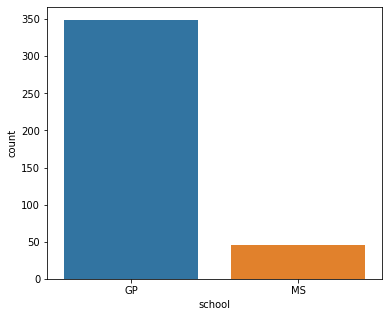

Процент пропусков:  0.0 %


### sex

пол ученика ('F' - женский, 'M' - мужской)

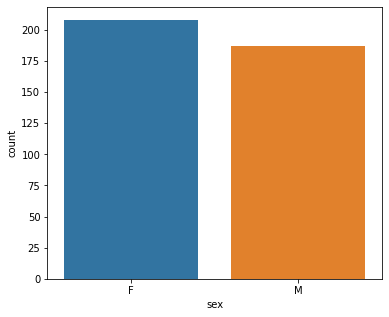

Процент пропусков:  0.0 %


### age

возраст ученика (от 15 до 22)

Ошибки не обнаружены


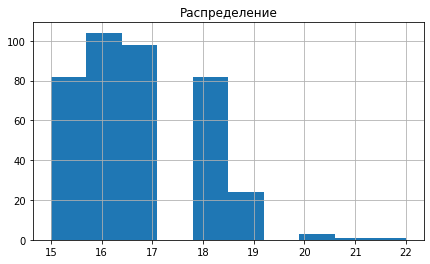

Процент пропусков:  0.0 %


### address

тип адреса ученика ('U' - городской, 'R' - за городом)

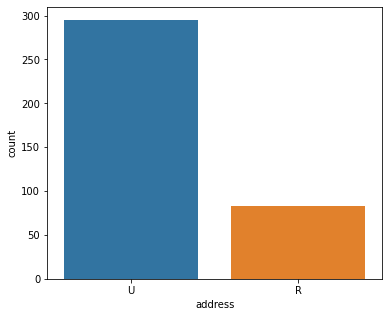

Процент пропусков:  4.3 %


### famsize

размер семьи('LE3' <= 3, 'GT3' >3)

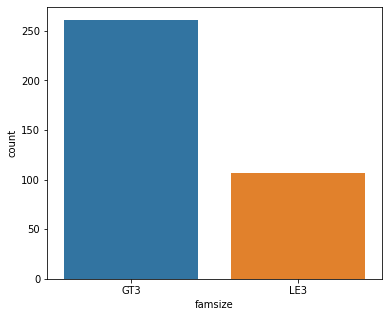

Процент пропусков:  6.84 %


### Pstatus

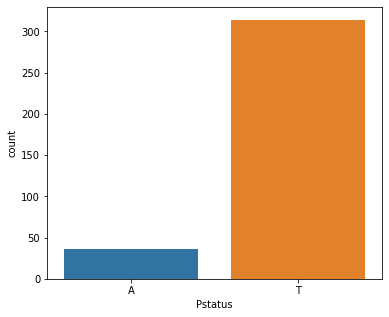

Процент пропусков:  11.39 %


### Medu

Ошибки не обнаружены


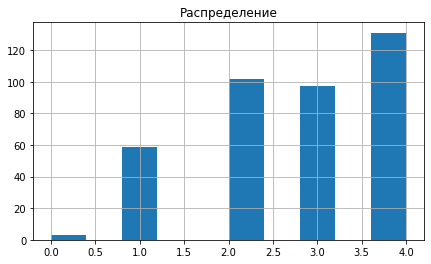

Процент пропусков:  0.76 %


### Fedu

Найдены выбросы по IQR в количестве:  1


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


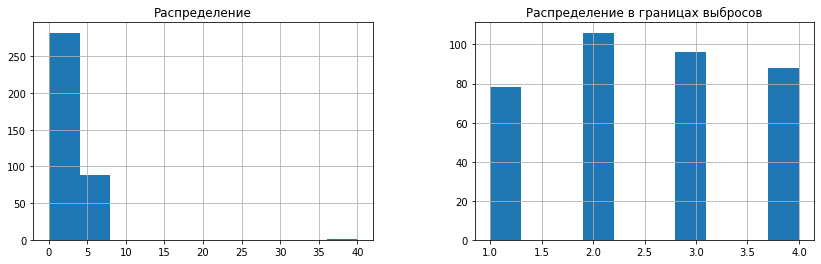

Процент пропусков:  6.08 %


### Mjob

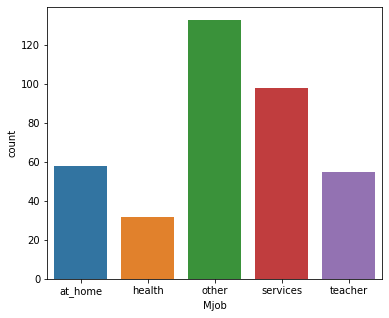

Процент пропусков:  4.81 %


### Fjob

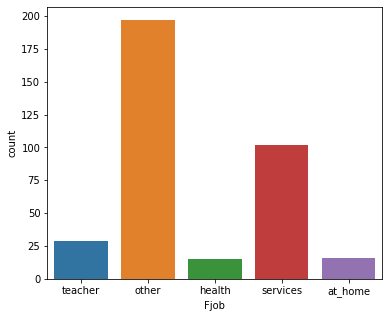

Процент пропусков:  9.11 %


### reason

причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

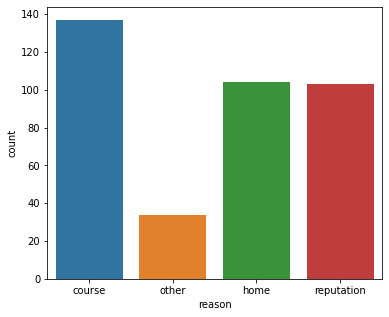

Процент пропусков:  4.3 %


### guardian

опекун ('mother' - мать, 'father' - отец, 'other' - другое)

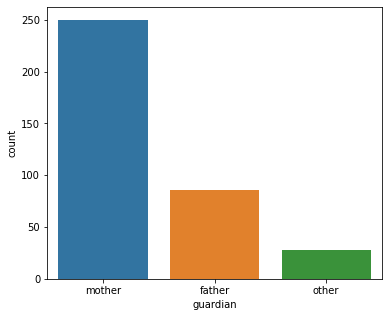

Процент пропусков:  7.85 %


### traveltime

время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

Ошибки не обнаружены


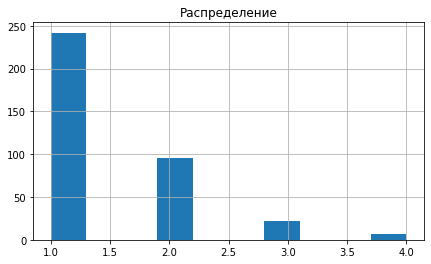

Процент пропусков:  7.09 %


### studytime

время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

Ошибки не обнаружены


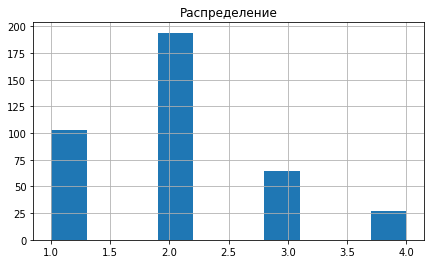

Процент пропусков:  1.77 %


### failures

количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

Ошибки не обнаружены


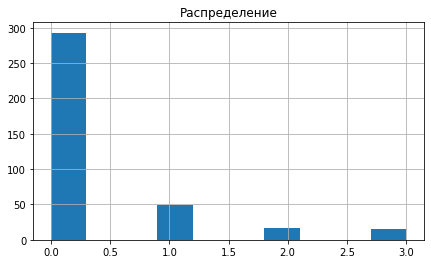

Процент пропусков:  5.57 %


### schoolsup

дополнительная образовательная поддержка (yes или no)

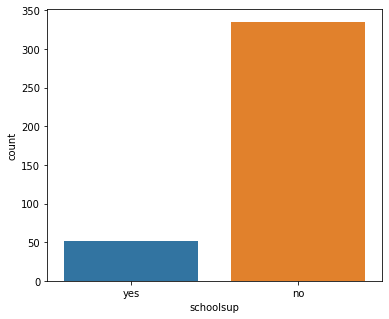

Процент пропусков:  2.28 %


### famsup

семейная образовательная поддержка (yes или no)

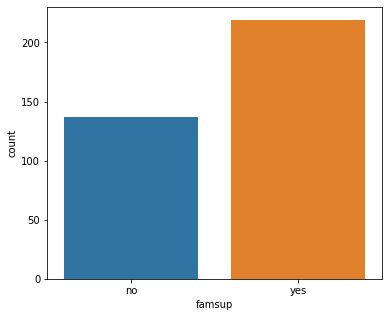

Процент пропусков:  9.87 %


### paid

дополнительные платные занятия по математике (yes или no)

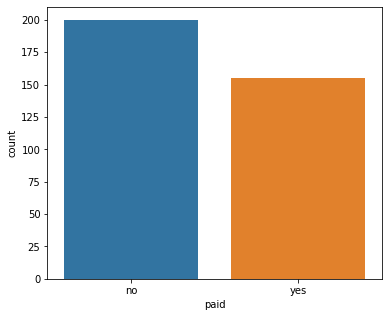

Процент пропусков:  10.13 %


### activities

дополнительные внеучебные занятия (yes или no)

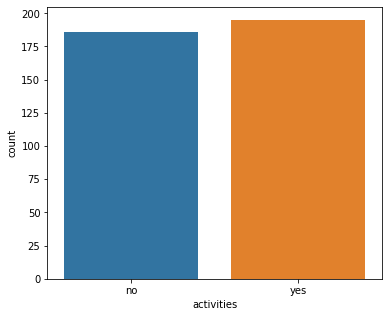

Процент пропусков:  3.54 %


### nursery

посещал детский сад (yes или no)

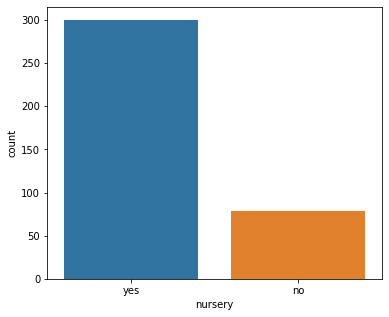

Процент пропусков:  4.05 %


### studytime, granular

Найдены ошибки в количестве:  27

Первые 10:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
47,GP,M,16,U,GT3,T,4.0,3.0,health,NaN,reputation,mother,1.0,4.0,0.0,no,no,no,yes,yes,-12.0,yes,yes,no,4.0,2.0,2.0,2.0,4.0,100.0
66,GP,M,15,U,GT3,A,4.0,4.0,other,services,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,no,-12.0,yes,yes,yes,1.0,3.0,3.0,3.0,4.0,60.0
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
69,GP,F,15,R,LE3,T,3.0,1.0,other,other,reputation,father,2.0,4.0,0.0,no,yes,no,no,no,-12.0,yes,yes,no,4.0,4.0,2.0,3.0,12.0,80.0
70,GP,M,16,U,GT3,T,3.0,1.0,other,other,reputation,father,NaN,4.0,0.0,no,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
71,GP,M,15,U,GT3,T,4.0,2.0,other,other,course,mother,1.0,4.0,0.0,no,no,no,no,yes,-12.0,yes,yes,no,3.0,3.0,3.0,3.0,0.0,50.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
77,GP,F,16,U,GT3,T,2.0,2.0,other,other,NaN,mother,1.0,4.0,0.0,no,no,yes,no,yes,-12.0,yes,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0
94,GP,M,15,U,LE3,T,2.0,2.0,services,health,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,yes,-12.0,yes,yes,no,NaN,3.0,4.0,4.0,6.0,70.0
95,GP,F,15,R,GT3,T,1.0,1.0,at_home,other,home,mother,2.0,4.0,1.0,yes,yes,yes,yes,yes,-12.0,yes,yes,no,3.0,1.0,2.0,1.0,2.0,50.0


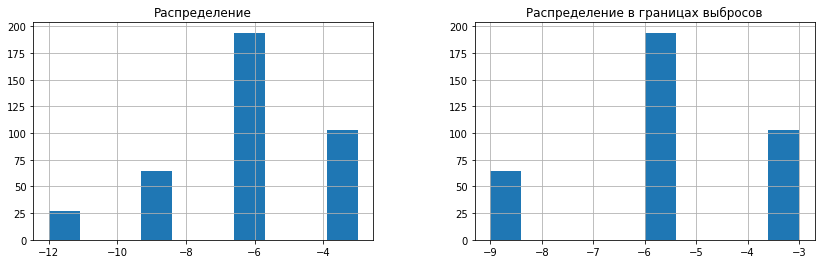

Процент пропусков:  1.77 %


### higher

хочет получить высшее образование (yes или no)

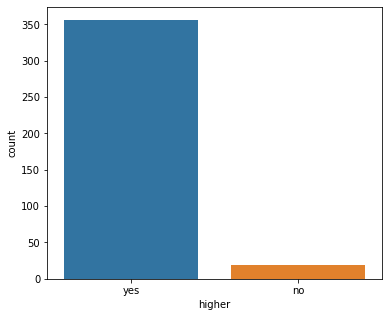

Процент пропусков:  5.06 %


### internet

наличие интернета дома (yes или no)

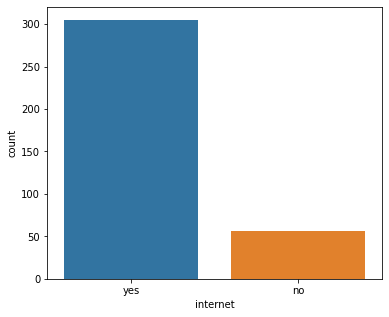

Процент пропусков:  8.61 %


### romantic

в романтических отношениях (yes или no)

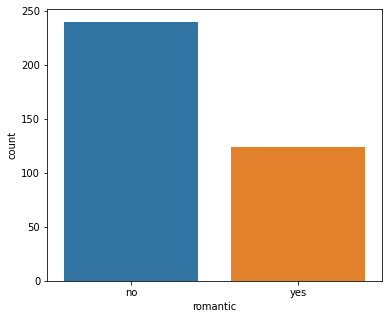

Процент пропусков:  7.85 %


### famrel

семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

Найдены выбросы по IQR в количестве:  1


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


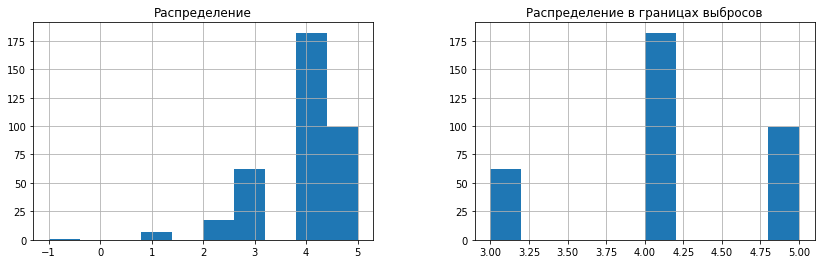

Процент пропусков:  6.84 %


### freetime

свободное время после школы (от 1 - очень мало до 5 - очень мого)

Ошибки не обнаружены


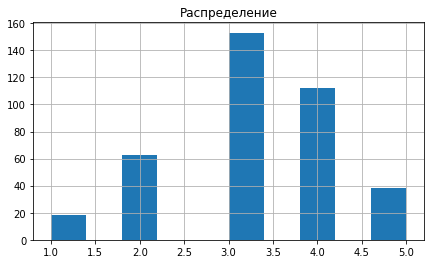

Процент пропусков:  2.78 %


### goout

проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

Ошибки не обнаружены


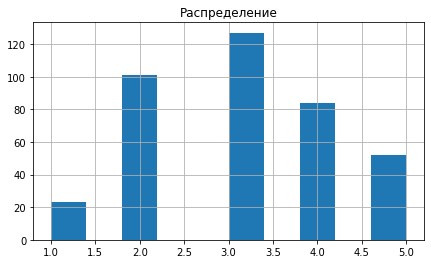

Процент пропусков:  2.03 %


### health

текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

Ошибки не обнаружены


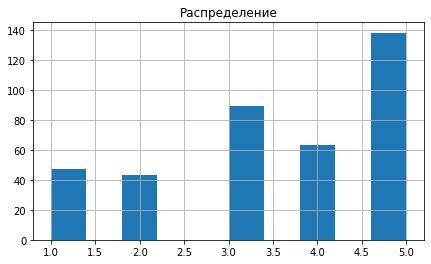

Процент пропусков:  3.8 %


### absences

количество пропущенных занятий

Найдены ошибки в количестве:  17

Первые 10:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,-6.0,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,NaN,no,no,no,-6.0,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0


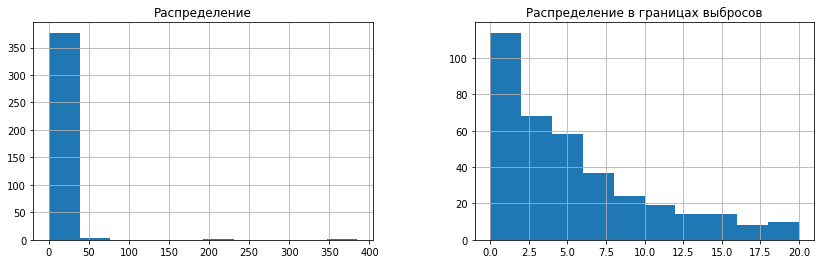

Процент пропусков:  3.04 %


### score

баллы по госэкзамену по математике

Ошибки не обнаружены


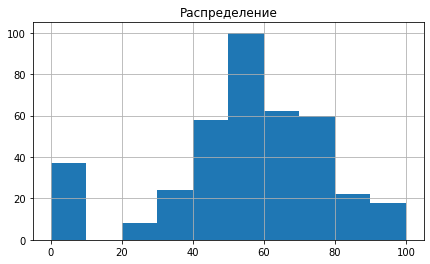

Процент пропусков:  1.52 %


In [79]:
for col in stud_math.columns:
    first_look(stud_math, col, outline_bounds, descriptions)

## Промежуточный выводы:

Данные достаточно чистые, однако есть некоторые проблемы, а именно:

 в некоторых переменных (higher, Pstatus, school, famrel) наблюдается дисбаланс классов;
 на основе age можно создать доп. переменную, объединяющую редких великовозрастных школьников;
 на основе признаков поддержки (schoolsup, famsup) можно создать признак наличия поддержки в общем виде;
 в переменных Fedu, famrel обнаружены ошибки: значения недопустимы по условию задания;
 в переменной Absences, "studytime,granular" в наличии выбросы;
 целевая переменная score содержит 1,5%: пропусков;
 распределение неописанной в задании studytime, granular напоминает распределение studytime.

<AxesSubplot:>

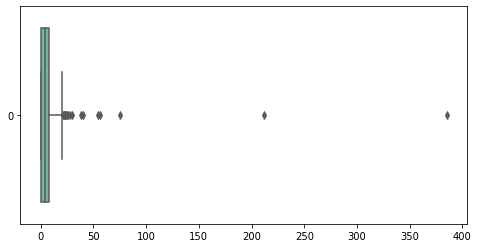

In [80]:
# Отдельно посмотрим на Absences
plt.figure(figsize=(8, 4))
sns.boxplot(data=stud_math['absences'], orient="h",
            palette="Set2", whis=1.5)

Как видно из графика, только 2 значения очень сильно выбиваются из общей массы. 
Их сложно объяснить логически и они, скорее всего, лишь запутают будущую модель. 
Так как мы работаем в условиях весьма ограниченного объема данных, то вместо удаления заменим их на типичное значение - медиану.

In [91]:
# Код предобработки по результатам анализа:
stud_math.fedu = stud_math.fedu.replace(40, 4)
stud_math.famrel = stud_math.famrel.replace(-1, 1)
stud_math.absences = stud_math.absences.apply(
    lambda x: stud_math.absences.median() if x > 100 else x)
stud_math['age_cat'] = stud_math.age.apply(
    lambda x: 'young' if x < 18 else 'old')
stud_math['is_sup'] = np.where((stud_math.schoolsup == 'yes') | (
    stud_math.famsup == 'yes'), 'yes', 'no')
stud_math.dropna(subset=['score'], inplace=True)

В переменной "studytime,granular" также в наличии выбросы, но пока с ними ничего делать не будем.
Рассмотрим подробнее нашу целевую переменную score

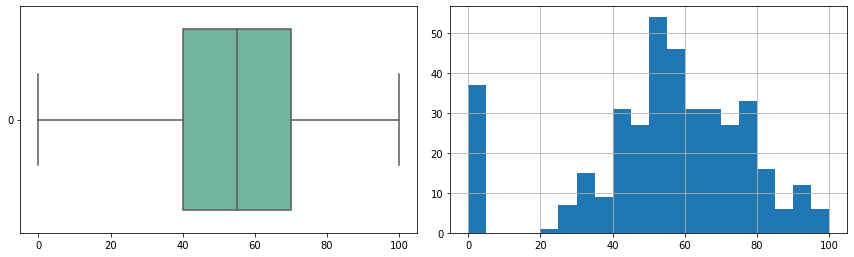

Ошибки не обнаружены


In [92]:
# Смотрим графики
fig, axes = plt.subplots(ncols=2, figsize=(6, 4))

sns.boxplot(data=stud_math['score'], orient="h",
            palette="Set2", whis=1.5, ax=axes[0])
stud_math.score.hist(bins=20, ax=axes[1])
fig.tight_layout(rect=[-1, 0.03, 1, 0.95])
plt.show()
search_mistakes(stud_math, 'score', outline_bounds)

## Обращаем внимание:¶


- более 30 учеников, получивших 0 баллов
- 'яма' в диапазоне от 0 до 20 после чего начинается нормальное распределение
- выбросов и ошибок нет
 
Провал, на наш взгляд, можно объяснить только наличием "проходного балла", т.е., если школьник не набрал "пороговое" значение 20, то ему проставлялся 0. Вообще, большое количество 0 оценок выглядит подозрительно. Но на этапе разведывательного анализа считаем, что правильнее эти значения оставить, и посмотреть сможет ли будущая модель предсказывать склонных к провалу экзамену учеников.


Корреляционный анализ количественных признаков.
Выясним какие столбцы коррелируют с оценкой на госэкзамене по математике. Это поможет понять какие признаки стоит оставить для модели, а какие нужно будет исключить из анализа

по количественным переменным:

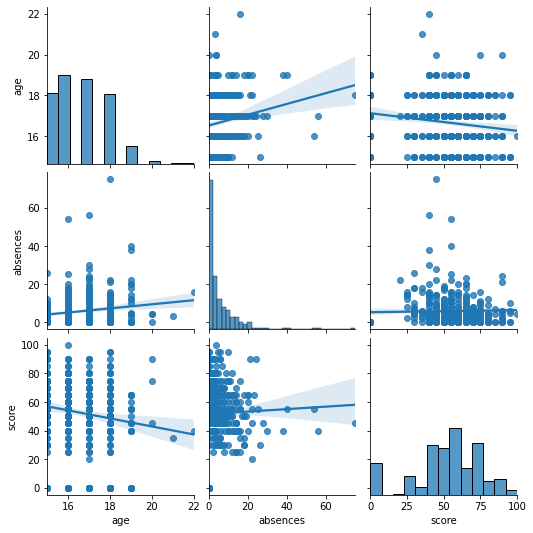

In [95]:
stud_num = ['age', 'absences', 'score']
sns.pairplot(stud_math[stud_num], kind='reg');

In [94]:
stud_math[stud_num].corr()

,age,absences,score
age,1.000000,0.169071,-0.155726
absences,0.169071,1.000000,0.030943
score,-0.155726,0.030943,1.000000


Как видим линейная связь "absences" со "score" очень незначительна. Проверим наличие нелинейной связи.

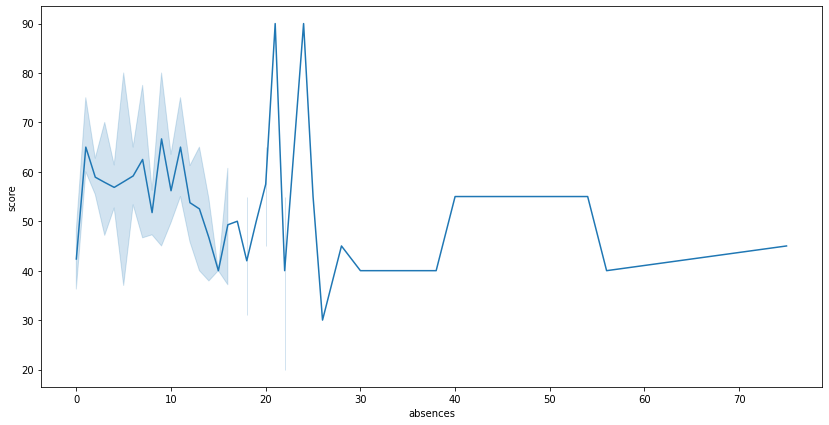

In [96]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stud_math, x='absences', y='score');

 Делаем вывод о низкой значимости предиктора для нашей модели

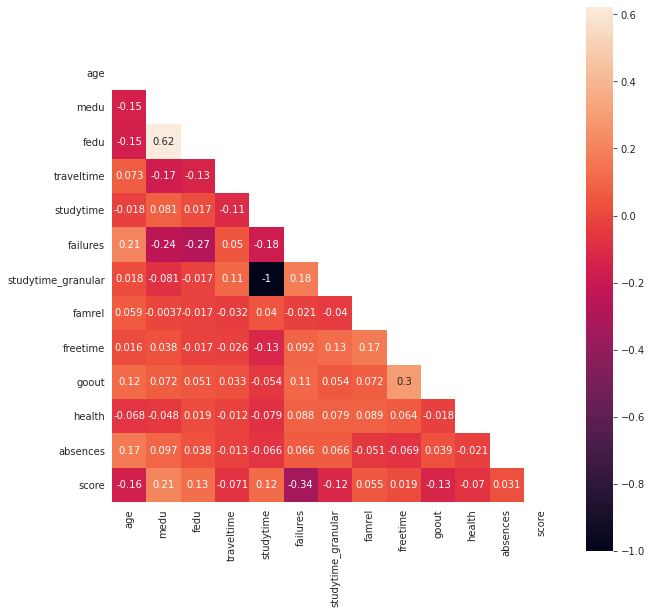

In [97]:
corr = stud_math.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr, mask=mask, annot=True, square=True)

Как видим, не описанная в условии переменная "studytime, granular" имеет полную обратную корреляцию (-1) с studytime. Соответственно, она не несет доп. информации и ее следует удалить. 
Также довольна сильная линейная зависимость между переменными Fedu, Medu (-0.15). Это можно использовать для:

 восстановления пропущенных значений
 генерации дополнительного признака на основе двух исходных.

In [98]:
# Сделаем отдельный датафрейм для кореллирующих значений
score_correlation_df = pd.DataFrame(stud_math.corr()["score"].values,
                                    index=stud_math.corr()["score"].index,
                                    columns=['correlation'])
score_correlation_df = score_correlation_df.drop("score")

score_correlation_df['corellation_amount'] = abs(
    score_correlation_df.correlation)
printmd("#### Кореллирующие значения в порядке убывания")
score_correlation_df.sort_values(by='corellation_amount', ascending=False)

#### Кореллирующие значения в порядке убывания

,correlation,corellation_amount
failures,-0.344338,0.344338
medu,0.213349,0.213349
age,-0.155726,0.155726
fedu,0.130923,0.130923
goout,-0.129685,0.129685
studytime,0.115741,0.115741
studytime_granular,-0.115741,0.115741
traveltime,-0.070559,0.070559
health,-0.070460,0.070460
famrel,0.055305,0.055305


Из этой таблицы делаем вывод, что больше всего в обучении мешают:
 1. количество внеучебных неудач
 2. Юный возраст 
 3. Проведение времени с друзьями
 
А позитивно на результатах сказывается: 
 1. Образование родителей 
 2. Самостоятельное обучение.
 
Менее значительно, позитивно влияют:
 1. семейные отношения
 
Как ни странно, количество прогулов и свободного времени после занятий не оказывает заметного влияния на результаты экзамена.

В целях очистки датасета, удалим стобцы с значением корелляции ниже 0.1, однако для будущей модели, возможно, их тоже можно было бы принять к рассмотрению, если останется время на эксперименты.

In [99]:
# Код предобработки на основе корреляционного анализа:
stud_math.drop('studytime_granular', axis=1, inplace=True)
stud_math.drop(
    score_correlation_df[score_correlation_df.corellation_amount < 0.1].index, axis=1, inplace=True)
stud_math['p_edu'] = stud_math['fedu']+stud_math['medu']

 # Визуальный анализ номинативных признаков, оценка количества уникальных значений.

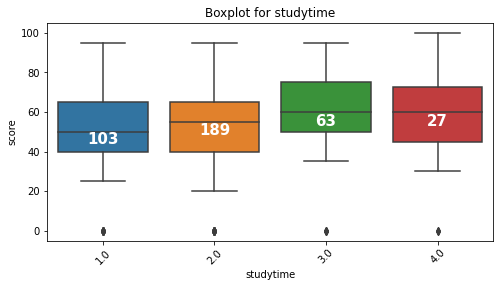

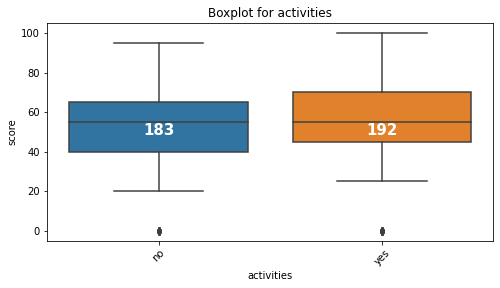

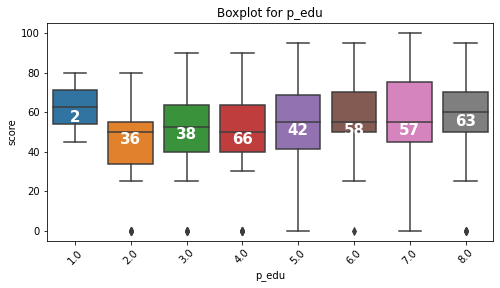

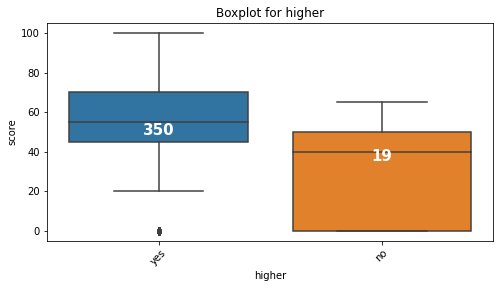

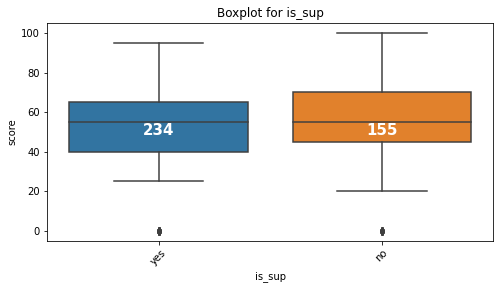

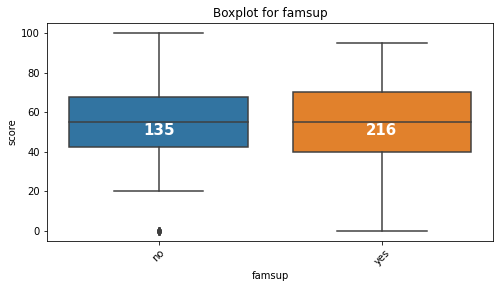

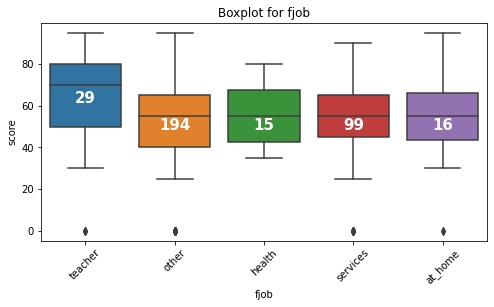

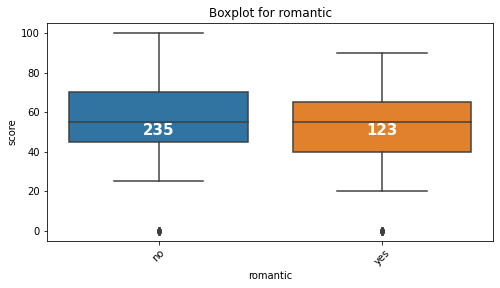

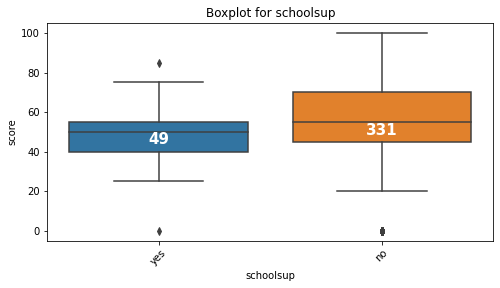

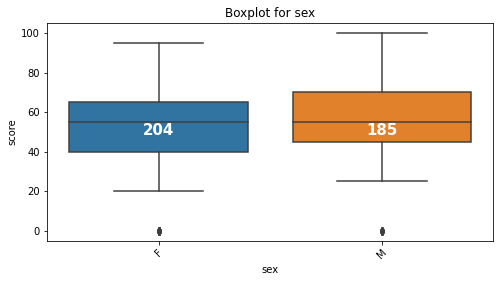

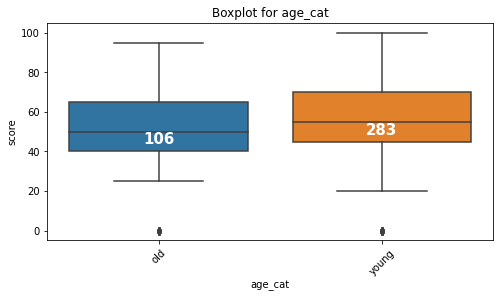

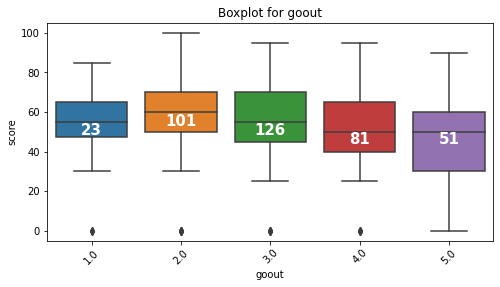

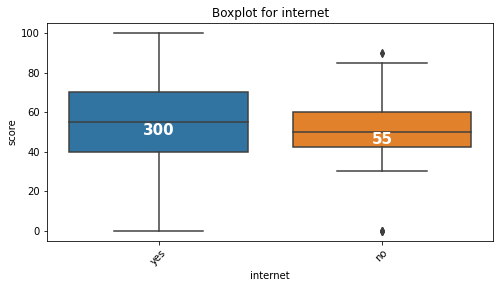

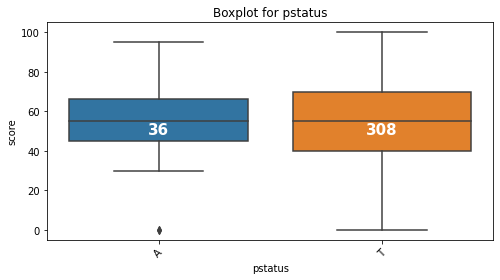

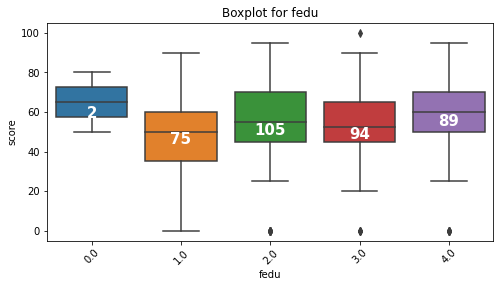

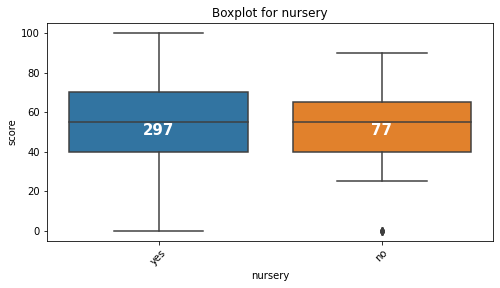

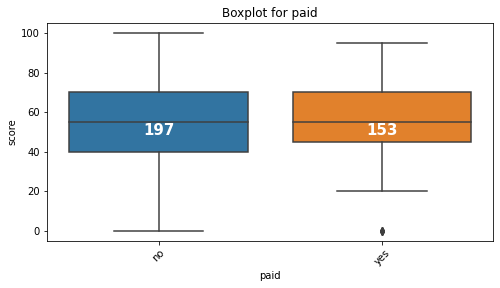

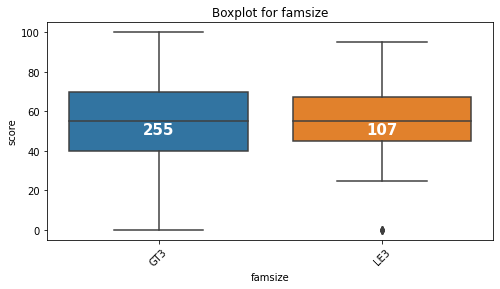

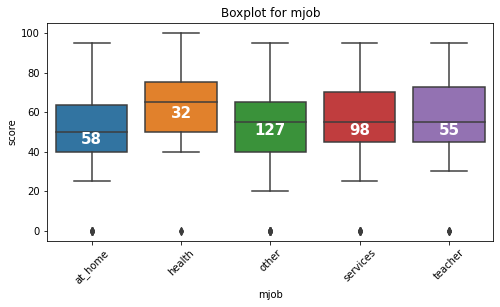

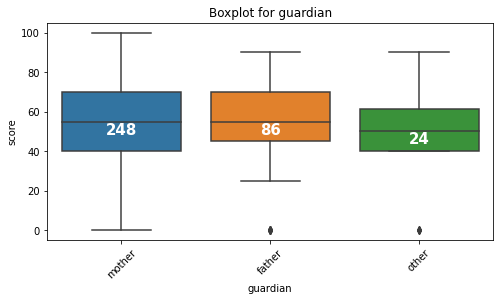

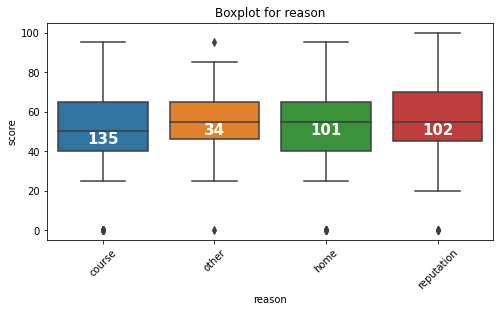

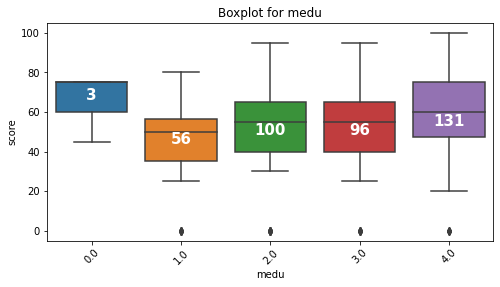

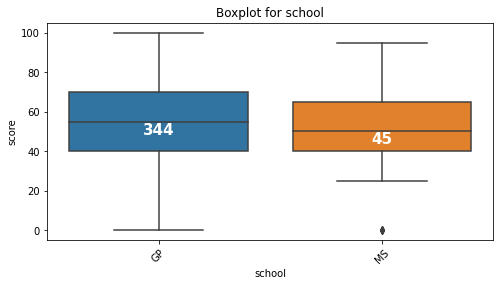

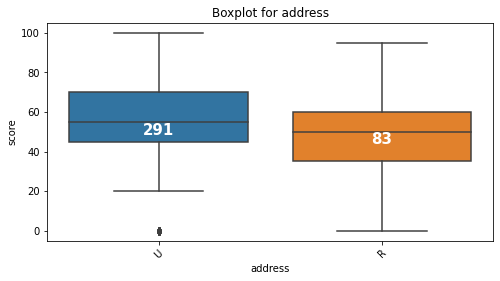

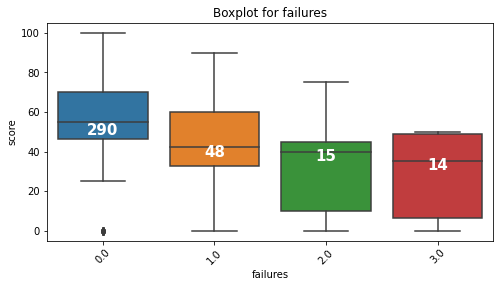

In [100]:
nom_cols = list(set(stud_math.columns) - set(['age', 'absences', 'score']))
for col in nom_cols:
    get_boxplot(stud_math, col)

In [101]:
stud_math['is_dad_teacher'] = stud_math.fjob.apply(lambda x: 1 if x=='teacher' else 0)

Промежуточный вывод:
После осмотра boxsplot перспективными для моделирования предикторами представляются:

schoolsup
Fedu
P_edu
failures
Mjob
Medu
is_dad_teacher
higher
age_cat
goout
school
address
studytime

t-test номинативных и смешанных переменных
С помощью теста Стьюдента проверим есть ли статистическая разница в распределении оценок по номинативным признакам, проверив нулевую гипотезу о том, что распределение оценок по госэкзамену в зависимости от уровней категорий неразличимы

In [102]:
nom_cols = list(set(stud_math.columns) - set(['age', 'absences', 'score']))
lst = []
for col in nom_cols:
    if get_stat_dif(stud_math, col):
        lst.append(col)

Найдены статистически значимые различия для колонки p_edu
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки age_cat
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки fedu
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки is_dad_teacher
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки failures


Тест Стьюдента и анализ номинативных переменных с помощью boxplot-графиков взаимодополняющие методы, а не взаимоисключающие. Поэтому на этапе EDA следует оставлять признаки, которые показались информативными и в первом и во втором случае.

In [103]:
# Итоговый датафрейм:
list_columns = set(['schoolsup', 'fedu', 'p_edu', 'failures', 'mjob', 'medu', \
                    'is_dad_teacher', 'higher', 'age_cat',  'goout', 'school', 'address', 'studytime', 'age', 'score'] + lst)
stud_math = stud_math[list_columns]

In [104]:
stud_math.head()

,studytime,fedu,score,paid,p_edu,mjob,higher,medu,romantic,age,school,schoolsup,is_dad_teacher,sex,age_cat,goout,address,failures
0,2.0,4.0,30.0,no,8.0,at_home,yes,4.0,no,18,GP,yes,1,F,old,4.0,U,0.0
1,2.0,1.0,30.0,no,2.0,at_home,yes,1.0,no,17,GP,no,0,F,young,3.0,U,0.0
2,2.0,1.0,50.0,NaN,2.0,at_home,yes,1.0,NaN,15,GP,yes,0,F,young,2.0,U,3.0
3,3.0,2.0,75.0,yes,6.0,health,yes,4.0,yes,15,GP,no,0,F,young,2.0,U,0.0
4,2.0,3.0,50.0,yes,6.0,other,yes,3.0,no,16,GP,no,0,F,young,2.0,U,0.0


Заполнение пропусков

Заполнение пропусков обширная и тонкая тема, и там иногда применяются весьма сложные техники. В нашей таблице не так уж и велико отношение количества пропусков к количеству всех элементов (не более 12%!), поэтому в данном случае имплементацией можно пренебречь.

Однако, да бы избежать с ошибками при подаче данных в ML алгоритм, как вариант, использовать простые способы заполнения пропусков. Кроме заполнения модой, номинативные признаки можно заполнять случайным значением переменной, с учетом вероятности появления уровня категории в заполненной переменной. Так, мы сохраним исходное распределение.

In [105]:
# Восстанавливаем пропущенные значения, используя сильную линейную зависимость:
stud_math.fedu = np.where(stud_math.fedu.isna(), stud_math.medu, stud_math.fedu)
stud_math.medu = np.where(stud_math.medu.isna(), stud_math.fedu, stud_math.medu)

#Заполняем числовые пропуски медианой, остальные - на основе вероятности появления 
for col in stud_math.columns:
    stud_math[col] = fill_na(stud_math, col, method='auto')

Итоговый вывод.¶
В результате проведенного EDA можно сделать следующие заключения относильно датасета:

Данные достаточно чистые:
количество пропущенных значений варьируется от 1% до 11%. Есть три переменные, в которых данные 100% заполнены;
ошибки обнаружены в переменных Fedu, famrel и заменены на основе некоторых предположений исходя из здравого смысла;
переменная Absences содержала 2 аномальных значения (>200), которые были заменены на медиану с целью сохранения информации, содержащейся в других предикторах.
После подробного осмотра распределений, было решено:
создать признак наличия поддержки в общем виде - is.sup, который оказался незначимым в итоге;
создать создать доп. переменную - age_cat, объединяющую редких великовозрастных школьников в одну группу;
удалить пропуски из целевой переменной за ненадобностью;
оставить 0 значения в score для выяснения возможности моделирования этих случаев.
В результате корреляционного анализа:
обнаружена сильная обратная корреляция между studytume и studytume_granular, поэтому один из них был удален за ненадобностью;
обнаружена линейная зависимость между Fedu, Medu, которая была использована для создания нового значимого признака и взаимного восстановления пропусков;
экспертно исключены пременные с коэффициентом корреляции менее 0.1 по модулю как самые бесперспективные на этапе EDA.
Анализ номинативных и смешанных переменных с помощью boxplot и t-testa позволил выделить следующие значимые признаки:
age_cat, goout, sex, paid, is_dad_teacher, Mjob, failures, Medu, Fedu, address, romantic, schoolsup, school, studytime, higher, P_edu
Итоговый ответ:
Для дальнейшего моделирования рекомендуется использовать параметры: sex, address, Mjob, schoolsup, paid, higher, romantic, age, Medu, Fedu, studytime, failures, goout - как наиболее перспективные.